<a href="https://colab.research.google.com/github/Qm1ne/GameDesignBalance/blob/main/ChkobaAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Setting up the project

**Importing Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing Libs and Dir**

In [3]:
pip install gymnasium

In [4]:
pip install stable-baselines3

In [5]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


**Creating Folder structure**

In [6]:

project_root = "/content/drive/MyDrive/chkoba_balancing"

# Create the folder if it doesn't exist
if not os.path.exists(project_root):
    os.makedirs(project_root)
    print(f"✅ Created folder: {project_root}")
else:
    print(f"📂 Folder already exists: {project_root}")

# Set working directory to the project folder
os.chdir(project_root)
print("📌 Current working directory:", os.getcwd())

📂 Folder already exists: /content/drive/MyDrive/chkoba_balancing
📌 Current working directory: /content/drive/MyDrive/chkoba_balancing


In [7]:
folders = ["envs", "models", "data", "plots", "tests", "logs", "configs"]
for folder in folders:
    os.makedirs(os.path.join(project_root, folder), exist_ok=True)


# 2- Creating Chkoba_env

First we are going to create an enviorment

In [13]:
import gym
import numpy as np
from gym import spaces
from collections import defaultdict
import random

class ChkobaEnv(gym.Env):
    def __init__(self, num_players=2):
        super(ChkobaEnv, self).__init__()

        self.num_players = num_players
        self.current_player = 0

        # Card representation: 40 cards total
        # Suits: 0=Coins(Dineri), 1=Cups, 2=Swords, 3=Clubs
        # Values: 1-7, J(8), Q(9), K(10)
        self.suits = 4
        self.values_per_suit = 10  # 1-7, J(8), Q(9), K(10)
        self.total_cards = 40

        # Game state
        self.deck = []
        self.table_cards = []
        self.initial_table_cards = []
        self.player_hands = []
        self.player_captured = []
        self.player_chkobas = []
        self.cards_played_this_round = 0
        self.total_rounds = 0

        # Define observation space
        obs_size = 40 + 40 + num_players + num_players + 1 + 1
        self.observation_space = spaces.Box(low=0, high=40, shape=(obs_size,), dtype=np.float32)

        # Action space: Now includes card selection + capture combination selection
        self.action_space = spaces.Discrete(30)
        self.current_valid_actions = []

    def _create_deck(self):
        """Create a standard 40-card deck"""
        deck = []
        for suit in range(4):
            for value in range(1, 11):  # 1-7, 8(J), 9(Q), 10(K)
                deck.append((suit, value))
        return deck

    def _card_to_index(self, card):
        """Convert card tuple to unique index"""
        suit, value = card
        return suit * 10 + (value - 1)

    def _index_to_card(self, index):
        """Convert index back to card tuple"""
        suit = index // 10
        value = (index % 10) + 1
        return (suit, value)

    def _get_card_value(self, card):
        """Get the game value of a card"""
        suit, value = card
        return value

    def reset(self):
        """Reset the game state"""
        # Initialize deck and shuffle
        self.deck = self._create_deck()
        random.shuffle(self.deck)

        # Reset game state
        self.table_cards = []
        self.initial_table_cards = []
        self.player_hands = [[] for _ in range(self.num_players)]
        self.player_captured = [[] for _ in range(self.num_players)]
        self.player_chkobas = [0 for _ in range(self.num_players)]
        self.current_player = 0
        self.cards_played_this_round = 0
        self.total_rounds = 0

        # Deal initial cards
        # First, place 4 cards on the table
        for _ in range(4):
            card = self.deck.pop()
            self.table_cards.append(card)
            self.initial_table_cards.append(card)

        # Then deal 3 cards to each player
        for _ in range(3):
            for player in range(self.num_players):
                self.player_hands[player].append(self.deck.pop())

        observation = self._get_observation()
        return observation, {"initial_table_cards": self.initial_table_cards}

    def _calculate_capture_reward(self, captured_cards):
        """Calculate reward for capturing cards with strategic bonuses"""
        if not captured_cards:
            return -0.05

        reward = 0

        # Base reward: 0.1 * number of captured cards
        reward += 0.5 * len(captured_cards)

        # Strategic card bonuses
        for card in captured_cards:
            suit, value = card

            # Seven of diamonds (Il 7ayya) - highest priority
            if suit == 0 and value == 7:  # Suit 0 = Coins/Dineri (diamonds)
                reward += 1

            # Other sevens
            elif value == 7:
                reward += 0.5

            # Other diamond cards
            elif suit == 0:
                reward += 0.25

        return reward

    def _find_capture_combinations(self, played_card):
        """Find all possible combinations of table cards that can be captured"""
        card_value = self._get_card_value(played_card)
        table_values = [self._get_card_value(card) for card in self.table_cards]
        combinations = []

        # Check for exact matches first
        for i, table_card in enumerate(self.table_cards):
            if self._get_card_value(table_card) == card_value:
                combinations.append([i])

        # Check for sum combinations
        def find_sum_combinations(target, cards_indices, current_combination=[]):
            if target == 0:
                if len(current_combination) > 1:  # Only combinations with 2+ cards
                    combinations.append(current_combination[:])
                return

            for i in range(len(cards_indices)):
                idx = cards_indices[i]
                card_val = table_values[idx]
                if card_val <= target:
                    current_combination.append(idx)
                    find_sum_combinations(target - card_val, cards_indices[i+1:], current_combination)
                    current_combination.pop()

        available_indices = list(range(len(self.table_cards)))
        find_sum_combinations(card_value, available_indices)

        # Sort combinations by strategic value (prioritize valuable cards)
        def combination_value(combo):
            value = 0
            for idx in combo:
                card = self.table_cards[idx]
                suit, card_value = card
                if suit == 0 and card_value == 7:  # Seven of diamonds
                    value += 1.0
                elif card_value == 7:  # Other sevens
                    value += 0.5
                elif suit == 0:  # Other diamonds
                    value += 0.25
                else:
                    value += 0.5  # Base value per card
            return value

        combinations.sort(key=combination_value, reverse=True)
        return combinations

    def _get_valid_actions(self):
        """Get list of valid actions for current player with capture combinations"""
        current_hand = self.player_hands[self.current_player]
        valid_actions = []
        action_descriptions = []

        action_id = 0
        for card_idx, card in enumerate(current_hand):
            capture_combinations = self._find_capture_combinations(card)

            if capture_combinations:
                # Multiple capture options - let agent choose
                for combo_idx, combination in enumerate(capture_combinations):
                    valid_actions.append(action_id)
                    action_descriptions.append({
                        'card_idx': card_idx,
                        'card': card,
                        'combination': combination,
                        'type': 'capture'
                    })
                    action_id += 1
            else:
                # No capture possible - place on table
                valid_actions.append(action_id)
                action_descriptions.append({
                    'card_idx': card_idx,
                    'card': card,
                    'combination': None,
                    'type': 'place'
                })
                action_id += 1

        self.current_valid_actions = action_descriptions
        return valid_actions

    def step(self, action):
        """Execute one step in the environment"""
        valid_actions = self._get_valid_actions()

        if action not in valid_actions:
            # Invalid action
            return self._get_observation(), -10, False, False, {"error": "Invalid action"}

        # Get action description
        action_desc = self.current_valid_actions[action]
        card_to_play = action_desc['card']
        card_idx = action_desc['card_idx']
        combination = action_desc['combination']

        # Remove card from player's hand
        self.player_hands[self.current_player].pop(card_idx)

        reward = 0
        chkoba = False
        captured_cards = []
        placed_card = None

        if action_desc['type'] == 'capture' and combination is not None:
            # Capture the specified combination
            captured_cards = [card_to_play]  # Include the played card

            # Capture table cards in reverse order to maintain indices
            for idx in sorted(combination, reverse=True):
                captured_cards.append(self.table_cards.pop(idx))

            self.player_captured[self.current_player].extend(captured_cards)

            # Calculate strategic capture reward
            reward += self._calculate_capture_reward(captured_cards)

            # Check for chkoba (table cleared)
            if len(self.table_cards) == 0:
                self.player_chkobas[self.current_player] += 1
                chkoba = True
                reward += 1  # Bonus reward for chkoba

        else:
            # No capture possible or chosen - card goes to table
            self.table_cards.append(card_to_play)
            placed_card = card_to_play
            # Apply penalty for not capturing (already handled in _calculate_capture_reward)
            reward += self._calculate_capture_reward([])

        # Update game state
        self.cards_played_this_round += 1

        # Check if round is complete (all players played their cards)
        if self.cards_played_this_round == self.num_players * 3:
            self._deal_new_round()

        # Move to next player
        previous_player = self.current_player
        self.current_player = (self.current_player + 1) % self.num_players

        # Check if game is over
        terminated = len(self.deck) == 0 and all(len(hand) == 0 for hand in self.player_hands)

        if terminated:
            final_scores = self._calculate_final_scores()
            reward += final_scores[previous_player] * 2  # Scale up final scoring
            # Give remaining table cards to last player who captured
            last_capturer = self._get_last_capturer()
            if last_capturer is not None:
                self.player_captured[last_capturer].extend(self.table_cards)

        info = {
            "player": previous_player,
            "action_type": action_desc['type'],
            "played_card": card_to_play,
            "captured_cards": captured_cards,
            "placed_card": placed_card,
            "chkoba": chkoba,
            "strategic_reward": self._calculate_capture_reward(captured_cards) if captured_cards else self._calculate_capture_reward([]),
            "cards_on_table": len(self.table_cards),
            "opponent_hand": self.player_hands[self.current_player] if not terminated else []
        }

        return self._get_observation(), reward, terminated, False, info

    def _deal_new_round(self):
        """Deal new cards when round is complete"""
        if len(self.deck) >= self.num_players * 3:
            for _ in range(3):
                for player in range(self.num_players):
                    if len(self.deck) > 0:
                        self.player_hands[player].append(self.deck.pop())
            self.cards_played_this_round = 0
            self.total_rounds += 1

    def _get_last_capturer(self):
        """Get the player who made the last capture"""
        max_captured = max(len(cards) for cards in self.player_captured)
        for i, cards in enumerate(self.player_captured):
            if len(cards) == max_captured:
                return i
        return 0

    def _calculate_final_scores(self):
        """Calculate final scores based on Chkoba rules"""
        scores = [0] * self.num_players

        for player in range(self.num_players):
            # Chkobas
            scores[player] += self.player_chkobas[player]

            # Il Carta (most cards) - more than 20 cards
            if len(self.player_captured[player]) > 20:
                scores[player] += 1

            # Il 7ayya (7 of diamonds)
            seven_diamonds = (0, 7)  # Suit 0 = Coins/Dineri
            if seven_diamonds in self.player_captured[player]:
                scores[player] += 1

            # Il Barmila (3 sevens or 2 sevens + 3 sixes)
            sevens = sum(1 for card in self.player_captured[player] if self._get_card_value(card) == 7)
            sixes = sum(1 for card in self.player_captured[player] if self._get_card_value(card) == 6)

            if sevens >= 3 or (sevens >= 2 and sixes >= 3):
                scores[player] += 1

            # Il Dineri (6 or more diamond cards)
            diamonds = sum(1 for card in self.player_captured[player] if card[0] == 0)
            if diamonds >= 6:
                scores[player] += 1

        return scores

    def _get_observation(self):
        """Get current observation"""
        obs = np.zeros(self.observation_space.shape[0])
        idx = 0

        # Table cards (binary encoding)
        for card in self.table_cards:
            card_idx = self._card_to_index(card)
            obs[card_idx] = 1
        idx += 40

        # Current player hand (binary encoding)
        current_hand = self.player_hands[self.current_player]
        for card in current_hand:
            card_idx = self._card_to_index(card)
            obs[idx + card_idx] = 1
        idx += 40

        # Captured cards count for each player
        for player in range(self.num_players):
            obs[idx + player] = len(self.player_captured[player])
        idx += self.num_players

        # Chkoba count for each player
        for player in range(self.num_players):
            obs[idx + player] = self.player_chkobas[player]
        idx += self.num_players

        # Current player
        obs[idx] = self.current_player
        idx += 1

        # Cards remaining in deck
        obs[idx] = len(self.deck)

        return obs

    def render(self, mode='human'):
        """Render the current state"""
        print(f"\n=== CHKOBA GAME STATE ===")
        print(f"Current Player: {self.current_player}")
        print(f"Cards in deck: {len(self.deck)}")
        print(f"Table cards: {self.table_cards}")

        # Show available actions for current player
        valid_actions = self._get_valid_actions()
        print(f"\nAvailable actions for Player {self.current_player}:")
        for i, action_id in enumerate(valid_actions):
            action_desc = self.current_valid_actions[action_id]
            card = action_desc['card']
            if action_desc['type'] == 'capture':
                captured_cards = [self.table_cards[idx] for idx in action_desc['combination']]
                strategic_reward = self._calculate_capture_reward([card] + captured_cards)
                print(f"  Action {action_id}: Play {card} -> Capture {captured_cards} (Strategic reward: {strategic_reward:.2f})")
            else:
                print(f"  Action {action_id}: Play {card} -> Place on table")

        for player in range(self.num_players):
            print(f"\nPlayer {player}:")
            print(f"  Hand: {self.player_hands[player]}")
            print(f"  Captured: {len(self.player_captured[player])} cards")
            print(f"  Chkobas: {self.player_chkobas[player]}")

            # Show special cards captured
            special_cards = []
            for card in self.player_captured[player]:
                suit, value = card
                if suit == 0 and value == 7:
                    special_cards.append("7♦")
                elif value == 7:
                    special_cards.append(f"7{['♦','♥','♠','♣'][suit]}")
                elif suit == 0:
                    special_cards.append(f"{value}♦")
            if special_cards:
                print(f"  Special cards: {special_cards}")

        if len(self.deck) == 0 and all(len(hand) == 0 for hand in self.player_hands):
            scores = self._calculate_final_scores()
            print(f"\n=== FINAL SCORES ===")
            for player in range(self.num_players):
                print(f"Player {player}: {scores[player]} points")


Test

In [9]:
# Example usage
if __name__ == "__main__":
    env = ChkobaEnv()
    obs, info = env.reset()

    print("Initial observation shape:", obs.shape)
    env.render()

    # Play a few random moves
    for step in range(10):
        valid_actions = env._get_valid_actions()
        if valid_actions:
            action = random.choice(valid_actions)
            obs, reward, terminated, truncated, info = env.step(action)
            print(f"\nStep {step + 1}: Action {action}, Reward {reward}")
            print(f"Info: {info}")

            if terminated:
                print("Game Over!")
                env.render()
                break
        else:
            break

Initial observation shape: (86,)

=== CHKOBA GAME STATE ===
Current Player: 0
Cards in deck: 30
Table cards: [(2, 6), (1, 8), (3, 8), (2, 8)]

Available actions for Player 0:
  Action 0: Play (2, 1) -> Place on table
  Action 1: Play (1, 1) -> Place on table
  Action 2: Play (3, 5) -> Place on table

Player 0:
  Hand: [(2, 1), (1, 1), (3, 5)]
  Captured: 0 cards
  Chkobas: 0

Player 1:
  Hand: [(1, 5), (0, 3), (3, 10)]
  Captured: 0 cards
  Chkobas: 0

Step 1: Action 0, Reward -0.05
Info: {'player': 0, 'action_type': 'place', 'played_card': (2, 1), 'captured_cards': [], 'placed_card': (2, 1), 'chkoba': False, 'strategic_reward': -0.05, 'cards_on_table': 5, 'opponent_hand': [(1, 5), (0, 3), (3, 10)]}

Step 2: Action 1, Reward -0.05
Info: {'player': 1, 'action_type': 'place', 'played_card': (0, 3), 'captured_cards': [], 'placed_card': (0, 3), 'chkoba': False, 'strategic_reward': -0.05, 'cards_on_table': 6, 'opponent_hand': [(1, 1), (3, 5)]}

Step 3: Action 1, Reward -0.05
Info: {'player'

# 3- Running Chkoba Qlearning model



In [25]:
import pickle
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import time
import os

class ChkobaQLearning:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Q-table: state -> action -> value
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Training metrics
        self.training_scores = []
        self.training_rewards = []
        self.episode_lengths = []
        self.epsilon_history = []
        self.action_history = []
        self.episode_info = []

        # Evaluation metrics
        self.win_rates = []
        self.avg_scores = []
        self.chkoba_rates = []

    def _state_to_key(self, state):
        """Convert state observation to hashable key for Q-table"""
        # Discretize continuous state for Q-table
        # Focus on most important features to reduce state space

        # Table cards (first 40 elements)
        table_cards = tuple(state[:40].astype(int))

        # Current player hand (next 40 elements)
        hand_cards = tuple(state[40:80].astype(int))

        # Captured cards count (normalized)
        captured_counts = tuple((state[80:80+self.env.num_players] // 5).astype(int))

        # Chkoba counts
        chkoba_counts = tuple(state[80+self.env.num_players:80+2*self.env.num_players].astype(int))

        # Current player and cards remaining (simplified)
        current_player = int(state[-2])
        cards_remaining = min(int(state[-1] // 5), 8)  # Bucket cards remaining

        return (table_cards, hand_cards, captured_counts, chkoba_counts,
                current_player, cards_remaining)

    def choose_action(self, state, valid_actions, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            # Exploration: random action
            return random.choice(valid_actions)

        # Exploitation: best known action
        state_key = self._state_to_key(state)
        q_values = {action: self.q_table[state_key][action] for action in valid_actions}

        if not q_values or all(v == 0 for v in q_values.values()):
            # No experience with this state, choose randomly
            return random.choice(valid_actions)

        # Choose action with highest Q-value
        return max(q_values, key=q_values.get)

    def update_q_table(self, state, action, reward, next_state, next_valid_actions, terminated):
        """Update Q-table using Q-learning formula"""
        state_key = self._state_to_key(state)

        # Current Q-value
        current_q = self.q_table[state_key][action]

        # Calculate max Q-value for next state
        if terminated or not next_valid_actions:
            max_next_q = 0
        else:
            next_state_key = self._state_to_key(next_state)
            next_q_values = [self.q_table[next_state_key][a] for a in next_valid_actions]
            max_next_q = max(next_q_values) if next_q_values else 0

        # Q-learning update
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )

        self.q_table[state_key][action] = new_q

    def train(self, episodes=1000, save_interval=100, verbose=True):
        """Train the Q-learning agent"""
        print(f"🎯 Starting Q-learning training for {episodes} episodes...")
        start_time = time.time()

        for episode in range(episodes):
            state, info = self.env.reset()
            total_reward = 0
            episode_length = 0
            episode_actions = []
            episode_info_log = [{'initial_table_cards': info['initial_table_cards']}]

            while True:
                # Get valid actions
                valid_actions = self.env._get_valid_actions()
                if not valid_actions:
                    break

                # Choose action
                action = self.choose_action(state, valid_actions, training=True)
                episode_actions.append(self.env.current_valid_actions[action]['type'])

                # Take step
                next_state, reward, terminated, truncated, info = self.env.step(action)
                episode_info_log.append(info)
                total_reward += reward
                episode_length += 1

                # Get next valid actions for Q-update
                next_valid_actions = self.env._get_valid_actions() if not terminated else []

                # Update Q-table
                self.update_q_table(state, action, reward, next_state,
                                   next_valid_actions, terminated)

                state = next_state

                if terminated or truncated:
                    break

            # Decay epsilon
            if self.epsilon > self.min_epsilon:
                self.epsilon *= self.epsilon_decay

            # Record metrics
            final_scores = self.env._calculate_final_scores()
            self.training_scores.append(final_scores[0])  # Player 0's score
            self.training_rewards.append(total_reward)
            self.episode_lengths.append(episode_length)
            self.epsilon_history.append(self.epsilon)
            self.action_history.append(episode_actions)
            self.episode_info.append(episode_info_log)

            # Progress reporting
            if verbose and (episode + 1) % 100 == 0:
                avg_score = np.mean(self.training_scores[-100:])
                avg_reward = np.mean(self.training_rewards[-100:])
                print(f"Episode {episode + 1}: Avg Score: {avg_score:.2f}, "
                      f"Avg Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")

            # Save checkpoint
            if (episode + 1) % save_interval == 0:
                self.save_model(f"chkoba_q_model_ep{episode + 1}.pkl")

        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")
        print(f"📊 Final epsilon: {self.epsilon:.3f}")
        print(f"🎯 Average score (last 100 episodes): {np.mean(self.training_scores[-100:]):.2f}")

    def evaluate(self, episodes=100, opponent_strategy='random'):
        """Evaluate the trained agent"""
        print(f"🔍 Evaluating agent for {episodes} episodes...")

        eval_scores = []
        eval_rewards = []
        eval_chkobas = []
        eval_wins = 0

        original_epsilon = self.epsilon
        self.epsilon = 0  # No exploration during evaluation

        for episode in range(episodes):
            state, _ = self.env.reset()
            total_reward = 0

            while True:
                valid_actions = self.env._get_valid_actions()
                if not valid_actions:
                    break

                if self.env.current_player == 0:
                    # Our trained agent
                    action = self.choose_action(state, valid_actions, training=False)
                else:
                    # Opponent strategy
                    if opponent_strategy == 'random':
                        action = random.choice(valid_actions)
                    elif opponent_strategy == 'greedy':
                        # Simple greedy: choose highest immediate reward
                        best_action = valid_actions[0]
                        best_reward = -999
                        for action_id in valid_actions:
                            action_desc = self.env.current_valid_actions[action_id]
                            if action_desc['type'] == 'capture':
                                card = action_desc['card']
                                captured_cards = [self.env.table_cards[idx] for idx in action_desc['combination']]
                                reward = self.env._calculate_capture_reward([card] + captured_cards)
                                if reward > best_reward:
                                    best_reward = reward
                                    best_action = action_id
                        action = best_action

                next_state, reward, terminated, truncated, info = self.env.step(action)

                if self.env.current_player == 1:  # Track our agent's rewards
                    total_reward += reward

                state = next_state

                if terminated or truncated:
                    break

            # Record evaluation metrics
            final_scores = self.env._calculate_final_scores()
            eval_scores.append(final_scores[0])
            eval_rewards.append(total_reward)
            eval_chkobas.append(self.env.player_chkobas[0])

            if final_scores[0] > final_scores[1]:
                eval_wins += 1

        # Restore original epsilon
        self.epsilon = original_epsilon

        # Calculate metrics
        win_rate = eval_wins / episodes * 100
        avg_score = np.mean(eval_scores)
        avg_chkobas = np.mean(eval_chkobas)

        self.win_rates.append(win_rate)
        self.avg_scores.append(avg_score)
        self.chkoba_rates.append(avg_chkobas)

        print(f"📈 Evaluation Results:")
        print(f"   Win Rate: {win_rate:.1f}%")
        print(f"   Average Score: {avg_score:.2f}")
        print(f"   Average Chkobas: {avg_chkobas:.2f}")
        print(f"   Average Reward: {np.mean(eval_rewards):.2f}")

        return {
            'win_rate': win_rate,
            'avg_score': avg_score,
            'avg_chkobas': avg_chkobas,
            'scores': eval_scores,
            'rewards': eval_rewards
        }

    def save_model(self, filename):
        """Save the Q-learning model"""
        model_data = {
            'q_table': dict(self.q_table),
            'training_scores': self.training_scores,
            'training_rewards': self.training_rewards,
            'episode_lengths': self.episode_lengths,
            'epsilon_history': self.epsilon_history,
            'action_history': self.action_history,
            'episode_info': self.episode_info,
            'hyperparameters': {
                'learning_rate': self.learning_rate,
                'discount_factor': self.discount_factor,
                'epsilon': self.epsilon,
                'epsilon_decay': self.epsilon_decay,
                'min_epsilon': self.min_epsilon
            }
        }

        os.makedirs('models', exist_ok=True)
        filepath = os.path.join('models', filename)

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"💾 Model saved to {filepath}")

    def load_model(self, filename):
        """Load a saved Q-learning model"""
        filepath = os.path.join('models', filename)

        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        # Restore Q-table
        self.q_table = defaultdict(lambda: defaultdict(float))
        for state_key, actions in model_data['q_table'].items():
            for action, value in actions.items():
                self.q_table[state_key][action] = value

        # Restore training history
        self.training_scores = model_data.get('training_scores', [])
        self.training_rewards = model_datalog.get('training_rewards', [])
        self.episode_lengths = model_data.get('episode_lengths', [])
        self.epsilon_history = model_data.get('epsilon_history', [])
        self.action_history = model_data.get('action_history', [])
        self.episode_info = model_data.get('episode_info', [])

        # Restore hyperparameters
        hyperparams = model_data.get('hyperparameters', {})
        self.learning_rate = hyperparams.get('learning_rate', self.learning_rate)
        self.discount_factor = hyperparams.get('discount_factor', self.discount_factor)
        self.epsilon = hyperparams.get('epsilon', self.epsilon)
        self.epsilon_decay = hyperparams.get('epsilon_decay', self.epsilon_decay)
        self.min_epsilon = hyperparams.get('min_epsilon', self.min_epsilon)

        print(f"📂 Model loaded from {filepath}")

    def visualize_training(self, save_plots=True,filename='chkoba_training_analysis.png'):
        """Create comprehensive training visualizations"""
        if not self.training_scores:
            print("No training data to visualize!")
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Chkoba Q-Learning Training Analysis', fontsize=16, fontweight='bold')

        # 1. Training Scores
        axes[0, 0].plot(self.training_scores, alpha=0.3, color='blue', label='Raw Scores')
        if len(self.training_scores) > 50:
            # Moving average
            window = min(100, len(self.training_scores) // 10)
            moving_avg = np.convolve(self.training_scores, np.ones(window)/window, mode='valid')
            axes[0, 0].plot(range(window-1, len(self.training_scores)), moving_avg,
                           color='red', linewidth=2, label=f'Moving Avg ({window})')
        axes[0, 0].set_title('Training Scores Over Time')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Training Rewards
        axes[0, 1].plot(self.training_rewards, alpha=0.3, color='green', label='Raw Rewards')
        if len(self.training_rewards) > 50:
            window = min(100, len(self.training_rewards) // 10)
            moving_avg = np.convolve(self.training_rewards, np.ones(window)/window, mode='valid')
            axes[0, 1].plot(range(window-1, len(self.training_rewards)), moving_avg,
                           color='orange', linewidth=2, label=f'Moving Avg ({window})')
        axes[0, 1].set_title('Training Rewards Over Time')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Cumulative Reward')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Epsilon Decay
        axes[0, 2].plot(self.epsilon_history, color='purple', linewidth=2)
        axes[0, 2].set_title('Epsilon (Exploration Rate) Decay')
        axes[0, 2].set_xlabel('Episode')
        axes[0, 2].set_ylabel('Epsilon')
        axes[0, 2].grid(True, alpha=0.3)

        # 4. Episode Lengths
        axes[1, 0].plot(self.episode_lengths, alpha=0.3, color='brown', label='Raw Lengths')
        if len(self.episode_lengths) > 50:
            window = min(100, len(self.episode_lengths) // 10)
            moving_avg = np.convolve(self.episode_lengths, np.ones(window)/window, mode='valid')
            axes[1, 0].plot(range(window-1, len(self.episode_lengths)), moving_avg,
                           color='red', linewidth=2, label=f'Moving Avg ({window})')
        axes[1, 0].set_title('Episode Lengths Over Time')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Steps per Episode')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Action Type Distribution (last 100 episodes)
        recent_actions = self.action_history[-100:] if len(self.action_history) >= 100 else self.action_history
        action_counts = {'capture': 0, 'place': 0}
        for episode_actions in recent_actions:
            for action_type in episode_actions:
                action_counts[action_type] += 1

        if sum(action_counts.values()) > 0:
            axes[1, 1].pie(action_counts.values(), labels=action_counts.keys(), autopct='%1.1f%%',
                          colors=['lightgreen', 'lightcoral'])
            axes[1, 1].set_title('Action Distribution (Last 100 Episodes)')

        # 6. Score Distribution Histogram
        axes[1, 2].hist(self.training_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 2].axvline(np.mean(self.training_scores), color='red', linestyle='--',
                          linewidth=2, label=f'Mean: {np.mean(self.training_scores):.2f}')
        axes[1, 2].set_title('Score Distribution')
        axes[1, 2].set_xlabel('Score')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            os.makedirs('plots', exist_ok=True)
            filepath = os.path.join('plots', filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"📊 Training plots saved to {filepath}")

        plt.show()
    def export_metrics_json(self, filename="training_metrics.json"):
      data = {
          "episodes": [],
      }

      for i in range(len(self.training_scores)):
          data["episodes"].append({
              "score": self.training_scores[i],
              "reward": self.training_rewards[i],
              "length": self.episode_lengths[i],
              "epsilon": self.epsilon_history[i],
              "actions": self.action_history[i],
              "info": self.episode_info[i]
          })

      os.makedirs("logs", exist_ok=True)
      filepath = os.path.join("logs", filename)
      with open(filepath, "w") as f:
          json.dump(data, f, indent=2)

      print(f"🧾 Training metrics saved to {filepath}")

test

🎮 Chkoba Q-Learning Training Pipeline
🎯 Starting Q-learning training for 2000 episodes...
Episode 100: Avg Score: 2.20, Avg Reward: 25.76, Epsilon: 0.606
Episode 200: Avg Score: 2.37, Avg Reward: 25.48, Epsilon: 0.367
Episode 300: Avg Score: 2.08, Avg Reward: 26.15, Epsilon: 0.222
Episode 400: Avg Score: 1.96, Avg Reward: 25.79, Epsilon: 0.135
Episode 500: Avg Score: 2.21, Avg Reward: 25.72, Epsilon: 0.082
💾 Model saved to models/chkoba_q_model_ep500.pkl
Episode 600: Avg Score: 2.28, Avg Reward: 25.71, Epsilon: 0.049
Episode 700: Avg Score: 2.07, Avg Reward: 25.28, Epsilon: 0.030
Episode 800: Avg Score: 2.08, Avg Reward: 25.50, Epsilon: 0.018
Episode 900: Avg Score: 2.27, Avg Reward: 24.94, Epsilon: 0.011
Episode 1000: Avg Score: 2.22, Avg Reward: 24.95, Epsilon: 0.010
💾 Model saved to models/chkoba_q_model_ep1000.pkl
Episode 1100: Avg Score: 2.15, Avg Reward: 25.40, Epsilon: 0.010
Episode 1200: Avg Score: 2.13, Avg Reward: 25.12, Epsilon: 0.010
Episode 1300: Avg Score: 2.15, Avg Rewar

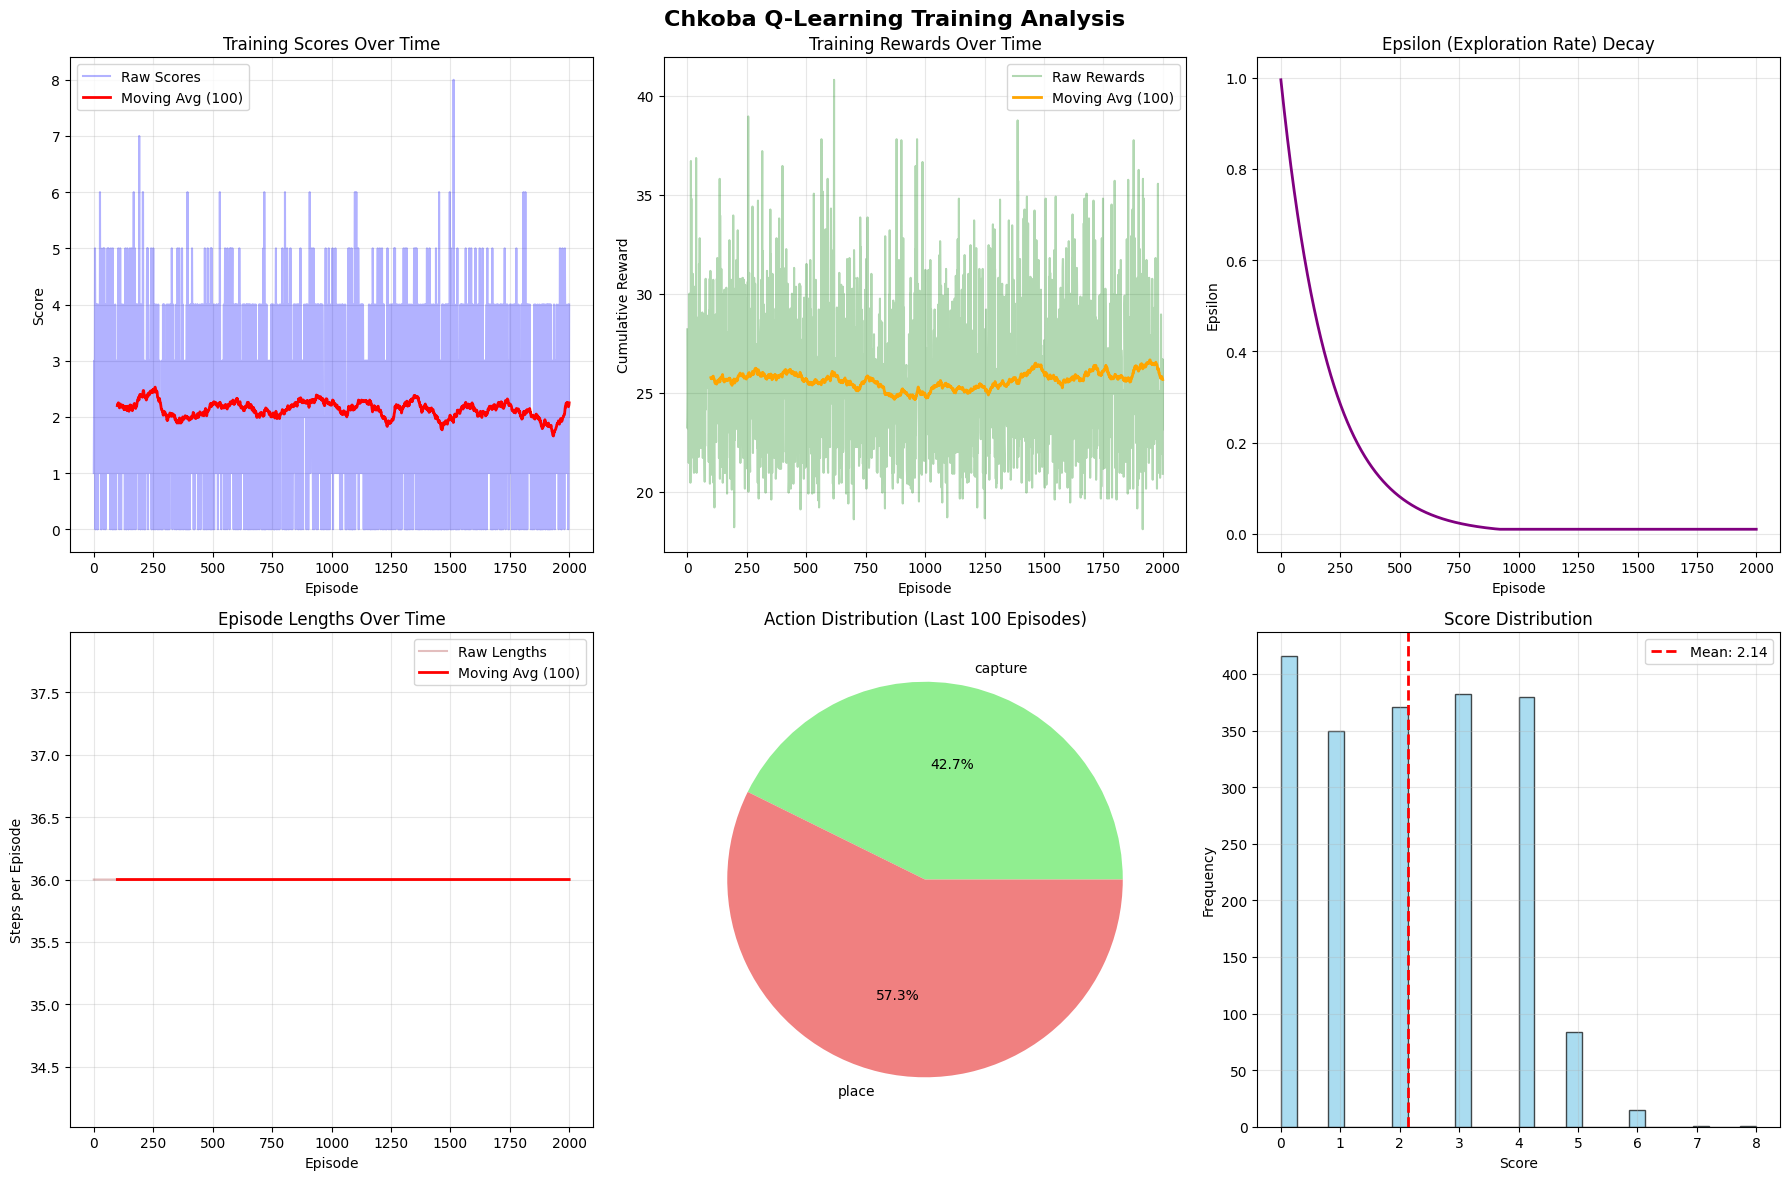


🏆 TRAINING COMPLETE!
📈 vs Random: 50.5% win rate
📈 vs Greedy: 24.0% win rate
💾 Model saved as 'chkoba_q_model_low_discount.pkl'
📊 Plots saved in 'plots/' directory
🧾 Logs saved in 'logs/' directory


In [26]:
def run_chkoba_training():
    """Complete training and evaluation pipeline"""
    print("🎮 Chkoba Q-Learning Training Pipeline")
    print("=" * 50)

    # Create environment and agent
    env = ChkobaEnv(num_players=2)
    agent = ChkobaQLearning(
        env=env,
        learning_rate=0.1,
        discount_factor=0.7,
        epsilon=1.0,
        epsilon_decay=0.995,
        min_epsilon=0.01
    )

    # Train the agent
    agent.train(episodes=2000, save_interval=500, verbose=True)

    # Evaluate against random opponent
    print("\n" + "="*50)
    random_results = agent.evaluate(episodes=200, opponent_strategy='random')

    # Evaluate against greedy opponent
    print("\n" + "="*50)
    greedy_results = agent.evaluate(episodes=200, opponent_strategy='greedy')

    # Save final model
    agent.save_model('chkoba_q_model_low_discount.pkl')

    # Create visualizations
    agent.visualize_training(save_plots=True, filename='chkoba_low_discount_training_results.png')

    # Export metrics to JSON
    #agent.export_metrics_json('chkoba_low_discount_training_metrics.json')

    # Print summary
    print("\n" + "="*50)
    print("🏆 TRAINING COMPLETE!")
    print(f"📈 vs Random: {random_results['win_rate']:.1f}% win rate")
    print(f"📈 vs Greedy: {greedy_results['win_rate']:.1f}% win rate")
    print(f"💾 Model saved as 'chkoba_q_model_low_discount.pkl'")
    print(f"📊 Plots saved in 'plots/' directory")
    print(f"🧾 Logs saved in 'logs/' directory")


if __name__ == "__main__":
     run_chkoba_training()


I am going to change the parameters to see if there is any diffrence

🎮 Chkoba Q-Learning Training Pipeline
🎯 Starting Q-learning training for 2000 episodes...
Episode 100: Avg Score: 1.99, Avg Reward: 25.16, Epsilon: 0.740
Episode 200: Avg Score: 2.19, Avg Reward: 26.24, Epsilon: 0.548
Episode 300: Avg Score: 2.37, Avg Reward: 25.25, Epsilon: 0.406
Episode 400: Avg Score: 2.28, Avg Reward: 25.39, Epsilon: 0.301
Episode 500: Avg Score: 2.43, Avg Reward: 25.20, Epsilon: 0.223
💾 Model saved to models/chkoba_q_model_ep500.pkl
Episode 600: Avg Score: 2.04, Avg Reward: 25.74, Epsilon: 0.165
Episode 700: Avg Score: 2.00, Avg Reward: 26.30, Epsilon: 0.122
Episode 800: Avg Score: 2.34, Avg Reward: 25.58, Epsilon: 0.090
Episode 900: Avg Score: 2.07, Avg Reward: 25.65, Epsilon: 0.067
Episode 1000: Avg Score: 1.97, Avg Reward: 25.64, Epsilon: 0.050
💾 Model saved to models/chkoba_q_model_ep1000.pkl
Episode 1100: Avg Score: 2.21, Avg Reward: 25.39, Epsilon: 0.050
Episode 1200: Avg Score: 1.86, Avg Reward: 25.55, Epsilon: 0.050
Episode 1300: Avg Score: 2.29, Avg Rewar

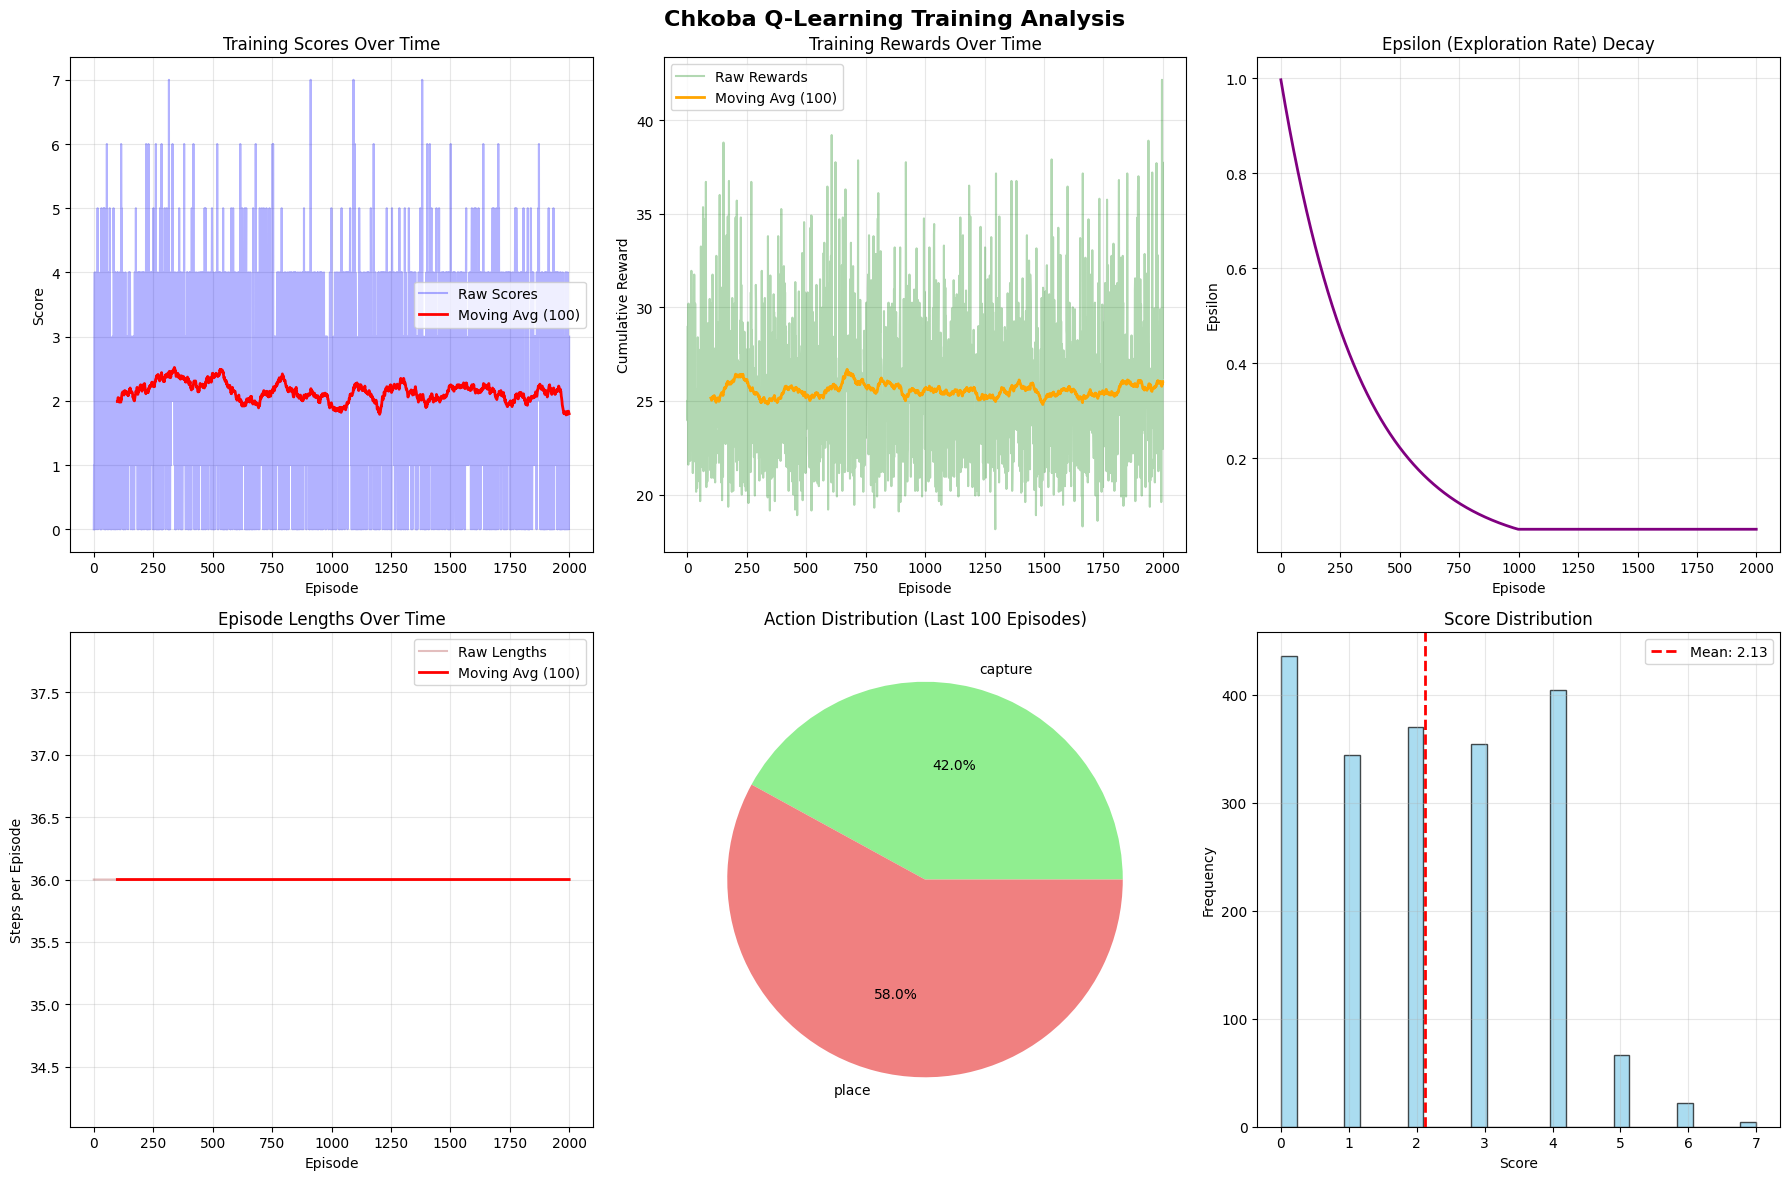


🏆 TRAINING COMPLETE!
📈 vs Random: 43.5% win rate
📈 vs Greedy: 25.5% win rate
💾 Model saved as 'chkoba_q_model_low_lr.pkl'
📊 Plots saved in 'plots/' directory
🧾 Logs saved in 'logs/' directory


In [28]:
def run_chkoba_training():
    """Complete training and evaluation pipeline"""
    print("🎮 Chkoba Q-Learning Training Pipeline")
    print("=" * 50)

    # Create environment and agent
    env = ChkobaEnv(num_players=2)
    agent = ChkobaQLearning(
        env=env,
        learning_rate=0.005,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.997,
        min_epsilon=0.05
    )

    # Train the agent
    agent.train(episodes=2000, save_interval=500, verbose=True)

    # Evaluate against random opponent
    print("\n" + "="*50)
    random_results = agent.evaluate(episodes=200, opponent_strategy='random')

    # Evaluate against greedy opponent
    print("\n" + "="*50)
    greedy_results = agent.evaluate(episodes=200, opponent_strategy='greedy')

    # Save final model
    agent.save_model('chkoba_q_model_low_lr.pkl')

    # Create visualizations
    agent.visualize_training(save_plots=True, filename='chkoba_low_lr_training_results.png')

    # Export metrics to JSON
    #agent.export_metrics_json('chkoba_low_lr_training_metrics.json')

    # Print summary
    print("\n" + "="*50)
    print("🏆 TRAINING COMPLETE!")
    print(f"📈 vs Random: {random_results['win_rate']:.1f}% win rate")
    print(f"📈 vs Greedy: {greedy_results['win_rate']:.1f}% win rate")
    print(f"💾 Model saved as 'chkoba_q_model_low_lr.pkl'")
    print(f"📊 Plots saved in 'plots/' directory")
    print(f"🧾 Logs saved in 'logs/' directory")


if __name__ == "__main__":
     run_chkoba_training()


# **Not the worst but still need improvment**`